# Machine Learning and Computational Statistics - Project

---

> Chalkiopoulos Georgios, Electrical and Computer Engineer NTUA <br />
> Data Science postgraduate Student <br />
> gchalkiopoulos@aueb.gr <br />
> p3352124

# Imports

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from pysptools.abundance_maps.amaps import NNLS, FCLS
from sklearn import linear_model
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.base import BaseEstimator
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# for creating a flattened plot
%matplotlib inline

plt.style.use('default')

# Load the data

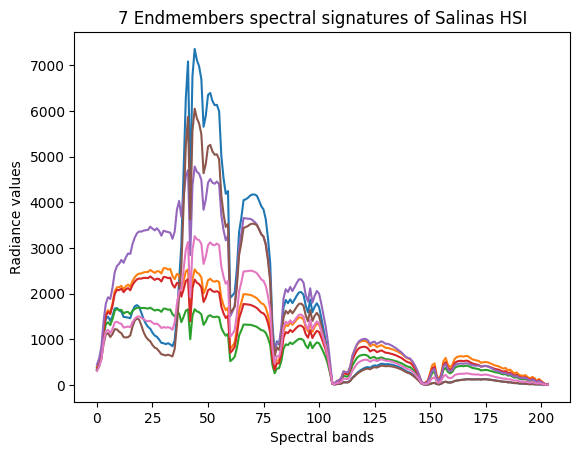

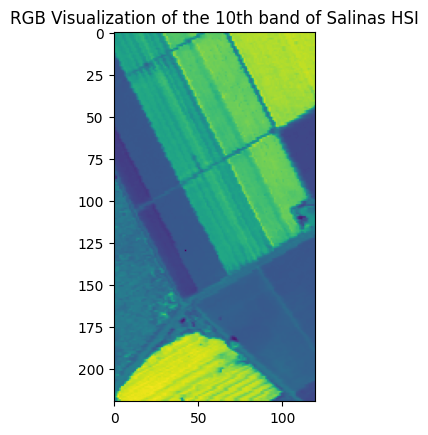

In [2]:

Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,45])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

# Define Variables and Functions

In [3]:
# Define variables
y = HSI
X = endmembers

In [4]:
def plot_endmembers(theta_table):
    # Create figures, axes
    fig, axes = plt.subplots(2, 4, figsize=(25, 7))

    pos = 0
    for i,triaxis in enumerate(axes):
        for j, axis in enumerate(triaxis):
            try:
                plot_theta = theta_table[:,:,pos]
                axis.imshow(plot_theta) 
                axis.set_xlabel(f'Position {pos}')
                pos += 1
            except IndexError:
                axis.imshow(np.zeros((220,120)))
                axis.set_xlabel(f'Unused position')
                break
    # Title
    fig.suptitle('RGB Visualization of abandance vector for each of 7 $\\theta$s', x=0.2, fontsize=20)
    fig.tight_layout(rect =(0, 0, 0.4, 1))


In [5]:
def r_error(abundance_map):
    error = np.zeros(shape=(220,120))
    reconstruct = np.zeros(shape=(220,120,204))
    for i, row in enumerate(labels):
        for j, l in enumerate(row):
            if l != 0:
                reconstruct[i,j,:] = np.dot(X, abundance_map[i,j,:].reshape(7,1)).flatten()
                error[i,j] = np.linalg.norm(y[i,j,:] - reconstruct[i,j,:])**2
    print(f'The reconstruction error is: {error.mean():.2f}')

In [6]:
def compare_tables(lebel_table, table_2):
    """Function to validate the number of zero values of a table compared to the number of zero values in the labels table.
    INPUT: label table, theta table of 220x120x7
    OUTPUT: None
    """
    # validation that the number of zero labels is the same as the number of theta with all zeros
    count_labels = 0
    for i in labels:
        if np.count_nonzero(i) > 0 :
            count_labels += 1
    count_labels

    count_theta = 0
    for i in range(0,220):
        for j in range(0,120):
            if np.count_nonzero(theta[i,j,:]) > 0 :
                count_theta += 1
    count_theta

    if count_labels == count_labels:
        print("Check is ok!")
    else:
        print(f"Number of non-zero elements in the labels table: {count_labels}")
        print(f"Number of non-zero elements in the theta table:\t {count_labels}\n")


# Part 1. Spectral unmixing

For each method we will estimate the abandance maps by iterating over the (non-zero-label) pixels. This is performed using the endmembers along with the image data (HSI).<br>
After calculating the maps, we will perform a sanity check, to see if the number of actual non zero labels is the same as the one we have, and will plot the error which is calculated as:<br>

$\Vert y_i - X\theta_i \Vert^2$

And averaged over the number of pixels.

The results for each method are presented below:

## 1.a. Least squares

In [7]:
# function to perform least squares
def perform_LS(X, y):
    """ Function to calculate the LS coeff. based on X (input) and y (output) tables"""

    # Calculate the LS tables
    Xx_inv = np.linalg.inv(X.T.dot(X))
    Xy = X.T.dot(y)

    return Xx_inv.dot(Xy).flatten()

Check is ok!
The reconstruction error is: 22481.51


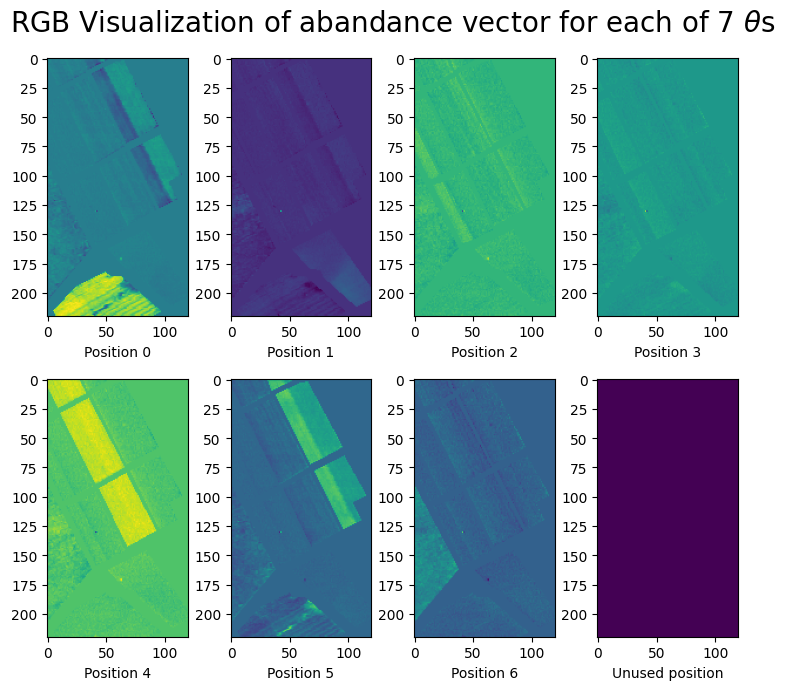

In [8]:
# define a table with zeros
theta = np.zeros(shape=(220,120,7))

# iterate throughput the labels table and if the label in non zero calculate theta for y [204x1] and X [204x7]
for i, row in enumerate(labels):
    for j, l in enumerate(row):
        if l != 0:
            y_row = y[i,j,:].reshape(-1,1)
            theta[i,j] = perform_LS(X, y_row)

compare_tables(labels, theta)  
r_error(theta)
plot_endmembers(theta)

## 1.b. Least squares imposing the sum-to-one constraint

In [9]:
# to be changed
def perform_LS_sum1(X,y):
    term_1 = perform_LS(X, y)

    ones = np.ones(endmembers.shape[1])
    lamda_num = (1-np.dot(ones.T,term_1))
    XTX = np.dot(X.T, X)
    inv = np.linalg.inv(XTX)
    lamda_den = np.dot(ones.T,np.dot(inv, ones))
    lamda = lamda_num/lamda_den

    theta_one_ = term_1 + np.dot(inv, lamda*ones)
    return theta_one_

Check is ok!
The reconstruction error is: 27626.70


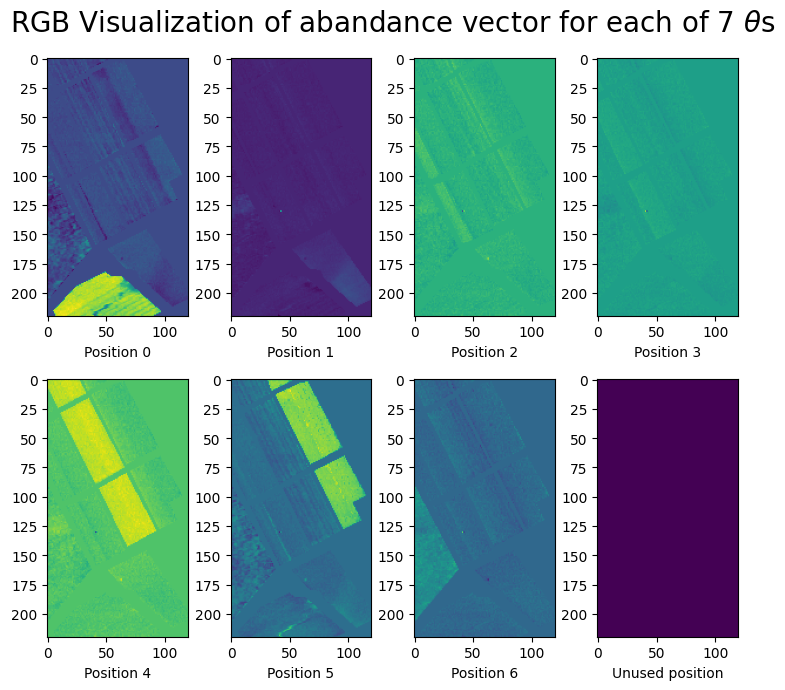

In [10]:
# define a table with zeros
theta_1 = np.zeros(shape=(220,120,7))

# iterate throughput the labels table and if the label in non zero calculate theta for y [204x1] and X [204x7]
for i, row in enumerate(labels):
    for j, l in enumerate(row):
        if l != 0:
            y_row = y[i,j,:].reshape(-1,1)
            theta_1[i,j] = perform_LS_sum1(X, y_row)

compare_tables(labels, theta_1)  
r_error(theta_1)
plot_endmembers(theta_1)

## 1.c. Least squares imposing the non-negativity constraint on the entries of $\theta$

Check is ok!
The reconstruction error is: 141692.34


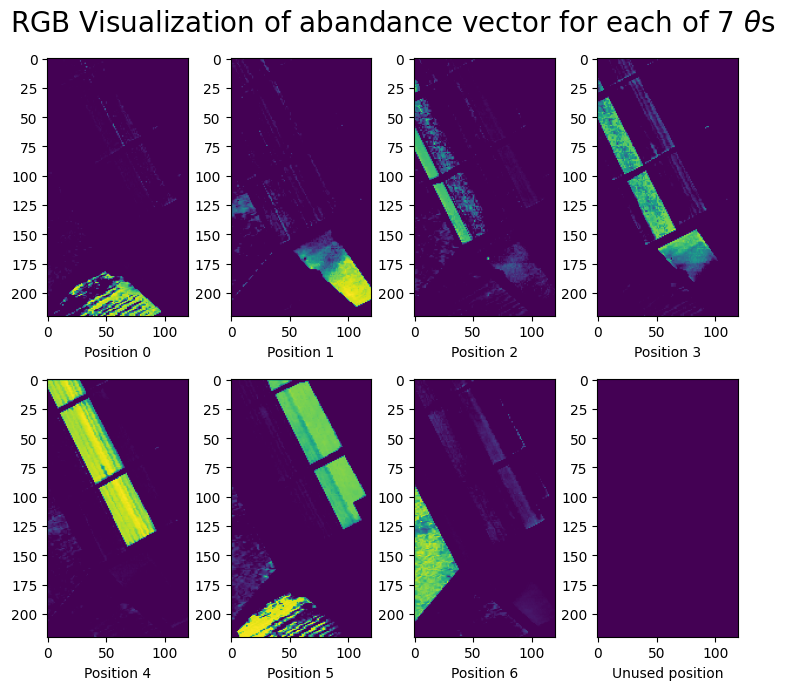

In [11]:
# define a table with zeros
theta_nnls = np.zeros(shape=(220,120,7))

# iterate throughput the labels table and if the label in non zero calculate theta for y [204x1] and X [204x7]
for i, row in enumerate(labels):
    for j, l in enumerate(row):
        if l != 0:
            y_row = y[i,j,:].reshape(-1,1)
            theta_nnls[i,j] = NNLS(y_row.astype(np.double).T, X.astype(np.double).T)

compare_tables(labels, theta_nnls)  
r_error(theta_nnls)
plot_endmembers(theta_nnls)

## 1.d. Least squares imposing both the non-negativity and the sum-to-one constraint on the entries of $\theta$.

Running...............................................Check is ok!
The reconstruction error is: 473708.72


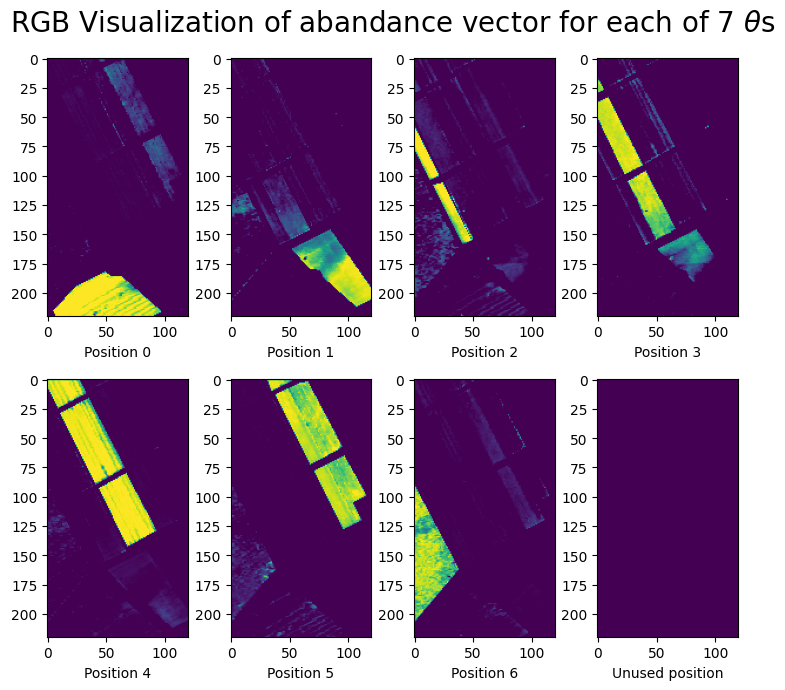

In [12]:
# define a table with zeros
theta_FCLS = np.zeros(shape=(220,120,7))

# iterate throughput the labels table and if the label in non zero calculate theta for y [204x1] and X [204x7]
print('Running...', end='')
for i, row in enumerate(labels):
    for j, l in enumerate(row):
        if l != 0:
            y_row = y[i,j,:].reshape(-1,1)
            theta_FCLS[i,j] = FCLS(y_row.astype(np.double).T, X.astype(np.double).T)
    if i%5 == 0:
        print('.', end='')

compare_tables(labels, theta_FCLS)  
r_error(theta_FCLS)
plot_endmembers(theta_FCLS) 

## 1.e. LASSO, i.e., impose sparsity on θ via 𝑙1 norm minimization.

Running...............................................Check is ok!
The reconstruction error is: 52506.22


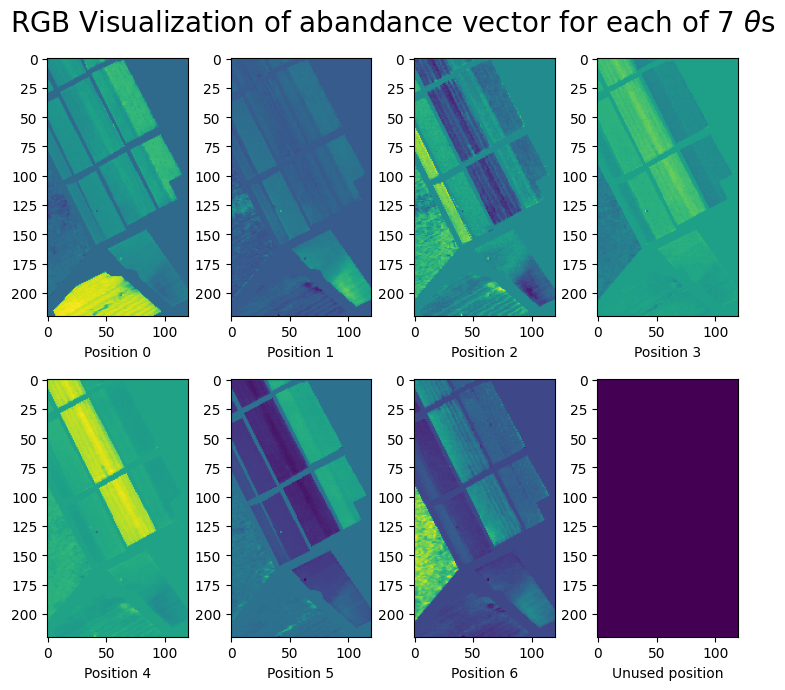

In [13]:
# define a table with zeros
theta_lasso = np.zeros(shape=(220,120,7))

# iterate throughput the labels table and if the label in non zero calculate theta for y [204x1] and X [204x7]
print('Running...', end='')
for i, row in enumerate(labels):
    for j, l in enumerate(row):
        if l != 0:
            clf = linear_model.Lasso()
            y_row = y[i,j,:].reshape(-1,1)
            clf.fit(X, y_row)
            theta_lasso[i,j] = clf.coef_
    if i%5 == 0:
        print('.', end='')


compare_tables(labels, theta_lasso)  
r_error(theta_lasso)
plot_endmembers(theta_lasso)  

## 1.Β. Compare the results obtained from the above five methods 

*(focusing on the abundance maps and the reconstruction error) and comment briefly on them (utilize the class information given in “Salinas_gt.mat”).

* We will first plot the abandance map of the ground truth in order to compare with the results obtained from each method.

In [14]:
def plot_labels(labels, fig_num):
    # keep list of non-zero value for each label
    plots = []
    for val in range(1,8):
        new = np.zeros(labels.shape)
        for i, row in enumerate(labels):
            for j, l in enumerate(row):
                if l == val:
                    new[i,j] = val
        plots.append(new)

    # Create figures, axes
    fig, axes = plt.subplots(2, 4, figsize=(25, 7))

    pos = 0
    for i,triaxis in enumerate(axes):
        for j, axis in enumerate(triaxis):
            try:
                axis.imshow(plots[pos]) 
                axis.set_xlabel(f'Label {pos+1}')
                pos += 1
            except IndexError:
                axis.imshow(np.zeros((220,120)))
                axis.set_xlabel(f'Unused position')
                break
    # Title
    fig.suptitle('RGB Visualization of abandance vector for each of 7 labels', x=0.2, fontsize=20)
    fig.supxlabel(f'Figure {fig_num}', x=0.2, y=0,fontsize=10)
    fig.tight_layout(rect =(0, 0, 0.4, 1))


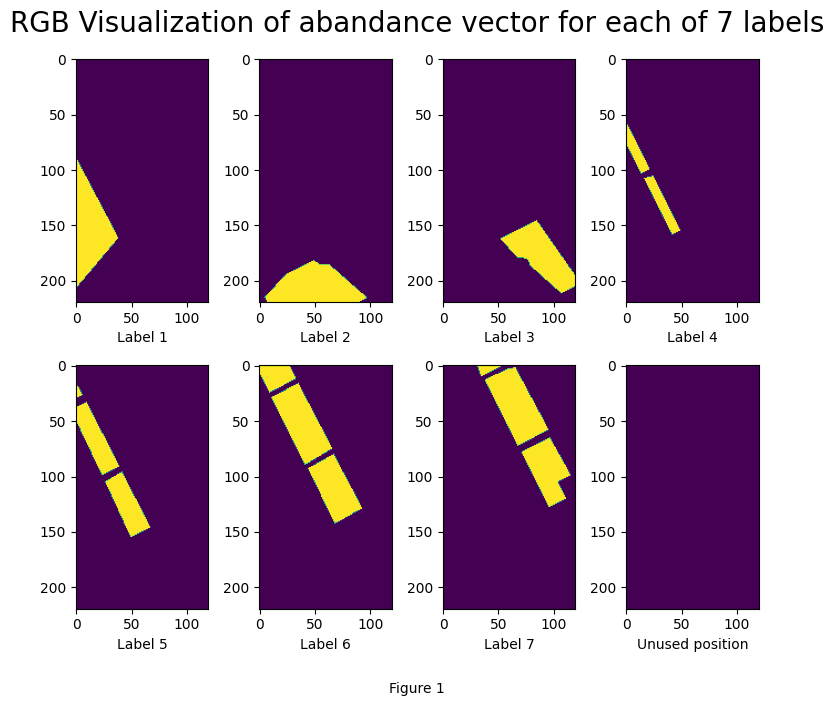

In [15]:
plot_labels(labels, 1)

#### Method comparison
In order to compare the results we extraced each class on it's own as seen from the figure above. Comparing this plot with the various methods we can conclude that the best results, which achieve class separation, are achieved using the LS with non-negativity & sum to one contrain method (best performer) followed by the LS with  non-negativity contrain. Both methods are able to distinguish the classes as shown in Figure 1. Looking at the endmembers, we can see that there is a difficutly in separating Endmembrs 3 and 5, which makes sense since the material is the same. 

Further analysing the results, we can see that the remaining methods are underperforming. Both the LASSO and the LS methods are are to separate and handfull of endmembers, witht the LS with the sum-to-one contrain performing marginally better. 

This is a clear example that in ML there is no one-size fits-all approach to the problem. More specifically, since our data is finite, our optimozation takes place in the constained space. In this regard, depending on the method, the solution $min_{\theta}J(\theta)$ might be better when imposing one constrain over the other (or even not imposing a contrain at all)*.

#### reconstruction error

Moving on to the reconstruction errors, we got the following results:

|Method|Reconstruction Error|
|---|---:|
|Least squares|22481.51|
|LS sum-to-one|27626.70|
|LS non-negativity|141692.34|
|LS non-negativity and sum-to-one|473708.72|
|LASSO ($l_1 norm)|52506.22|

The pattern here is clear. The more contrains we all, the higher the reconstruction error. Why is that?

An explanation could be that throught this procedure we are trying to keep only the meaningfull information of each endmember, for each pixel. By applying the contraings, we can see that we are removing the noise, and also achieving class separation. When we are reconstructing the pixels, we are using the "cleared" data, thus we are not reconstructing the error. 

Since these images are satelite ones, there is a great amount of noise in them. As a result, when imposing constrains, and getting better results in terms of noise reduction which results to endmember separation, we are removing this noise and reconstruct and "cleaner" image. When compared with the original one, that contains a lot of noise, the result is a higher reconstruction error. This, of course, does not mean that the results we are getting are worse, but rather, means that the image we are reproducing is matching less the original one (which contains noise).

*More info regarding this can be found in the corresponding lectures.


# Part 2 (classification)

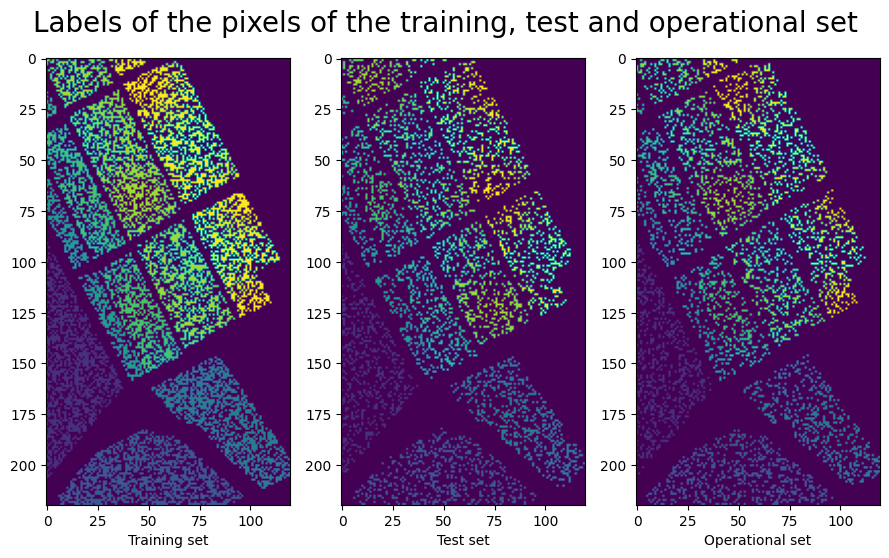

In [16]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T


# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

axes[0].imshow(Training_Set)
axes[1].imshow(Test_Set)
axes[2].imshow(Operational_Set)

axes[0].set_xlabel(f'Training set')
axes[1].set_xlabel(f'Test set')
axes[2].set_xlabel(f'Operational set')

# Title
fig.suptitle('Labels of the pixels of the training, test and operational set', x=0.3, y=0.75, fontsize=20)
fig.tight_layout(rect =(0, 0, 0.6, 1))


## Define datasets & Functions

In [17]:
def create_datasets(input_dataset):
    """
    Function to return the classifcation tables of non zero elements.
    INPUT: a table of 220x120 dimenstion
    OUTPUT: a matrix consisted of rows containing all the endmembers for a pixel along with the corresponding values of the label and the position of non-zero elements in a tuple
    """
    output_dataset = np.zeros((1,205))
    for i, row in enumerate(input_dataset):
        for j, l in enumerate(row):
            if l != 0:
                x_row = HSI[i,j,:].flatten()
                to_append = np.concatenate((x_row, np.array([l])))
                output_dataset = np.concatenate((output_dataset, [to_append]))

    return output_dataset[1:,:]

training_dataset = create_datasets(Training_Set)
test_dataset = create_datasets(Test_Set)
op_set = create_datasets(Operational_Set)

X_train, y_train = training_dataset[:,:-1], training_dataset[:,-1]
X_test, y_test= test_dataset[:,:-1], test_dataset[:,-1]
X_opt, y_opt = op_set[:,:-1], op_set[:,-1]

In [18]:
def plot_confusion_matrix(clf, X, y):
    print(f'Accuracy: {accuracy_score(clf.predict(X), y_test)*100:.2f}%\n')

    print("Confusion matrix:")
    cf_matrix = confusion_matrix(y, clf.predict(X), normalize='pred')
    
    # get unique labels 
    labels_y = np.unique(y, axis=0)

    # max value of cmatrix 
    max_cm = cf_matrix.max()
    ax = sns.heatmap(cf_matrix, annot=True,  fmt='.2%', xticklabels=labels_y, yticklabels=labels_y,
                cbar=False, vmin=0, vmax=max_cm)
    cbar = ax.figure.colorbar(ax.collections[0])
    cbar.set_ticks([0, max_cm])
    _ = cbar.set_ticklabels(["0%", f"{max_cm*100:.2f}%"])

## 2.A.i. Cross Validation

* This part only uses the train set, since we are performing 10-fold cross-validation. All methods, exept the minimum distance classifier, are available throughput sklearn.

In order to use the minimum distance classifier in sklearn, we created a class, which inherits the attributes from sklearn's BaseEstimator, thus we are able to use it with crossvalidation.

The Error and standar deviation are presented for each classifier below.

### a. Naïve Bayes classifier

In [19]:
nb = GaussianNB()
nb_error = 1 - cross_val_score(nb, X_train, y_train, cv=10)
print(f"The error mean is: {nb_error.mean()*100:.2f}% and the std is {nb_error.std()*100:.2f}%")

The error mean is: 2.62% and the std is 1.60%


### b. Minimum Euclidean distance classifier

In [20]:
#Actual algorithm implementation.
class Min_Distance_Classifier(BaseEstimator):
    
    def __init__(self, metric='euclidean'):
        self.class_list = {}
        self.mu = []
        self.metric = metric
    

    def fit(self, X, y):
        self.class_list = np.unique(y, axis=0)

        self.mu = np.zeros((len(self.class_list),X.shape[1]))
        for i in range(len(self.class_list)):
            # fit the GMM with 1 component to calculate the mean for each class
            gm = GaussianMixture(n_components=1, random_state=0).fit(X[y==i+1])
            self.mu[i] = gm.means_[0]
            
        return self

    def predict(self, X):
        temp = np.argmin(
            cdist(X, self.mu, metric=self.metric), # distance between each pair of the two collections of inputs
            axis=1
        )
        y_pred = np.array([self.class_list[i] for i in temp])
        return y_pred


In [21]:
md = Min_Distance_Classifier()
md_error = 1 - cross_val_score(md, X_train, y_train, cv=10, scoring='accuracy')
print(f"The error mean is: {md_error.mean()*100:.2f}% and the std is {md_error.std()*100:.2f}%")

The error mean is: 5.51% and the std is 7.68%


### c. k-nearest neighbor classifier 

In [22]:
kn = KNeighborsClassifier(3)
kn_error = 1 - cross_val_score(kn, X_train, y_train, cv=10)
print(f"The error mean is: {kn_error.mean()*100:.2f}% and the std is {kn_error.std()*100:.2f}%")

The error mean is: 0.89% and the std is 1.30%


### d. Bayesian classifier

In [23]:
qd = QuadraticDiscriminantAnalysis()
qd_error = 1 - cross_val_score(qd, X_train, y_train, cv=10)
print(f"The error mean is: {qd_error.mean()*100:.2f}% and the std is {qd_error.std()*100:.2f}%")

The error mean is: 3.43% and the std is 0.59%


## 2.A.ii. Evaluate on test set

In order to evalute the results we will use the entire training dataset for fit the data and make predictions on the test set. <br>
We will then use a confusion matrix to visually see the performance and calculate the accuracy (which is the same as calculating the sum of the diagonal minus, compared to the sum of the confusion matrix table).

* The results may be found below:

### a. Naïve Bayes classifier

Accuracy: 98.13%

Confusion matrix:


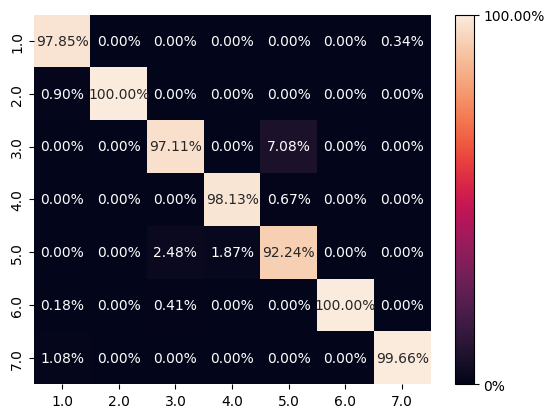

In [24]:
nb.fit(X_train, y_train)
plot_confusion_matrix(nb, X_test, y_test)

### b. Minimum Euclidean distance classifier

Accuracy: 95.91%

Confusion matrix:


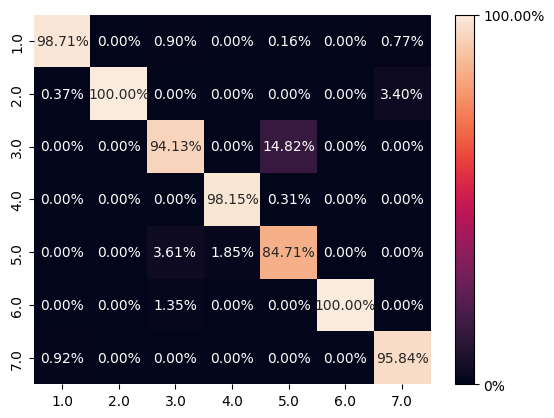

In [25]:
md.fit(X_train, y_train)
plot_confusion_matrix(md, X_test, y_test)

### c. k-nearest neighbor classifier 

Accuracy: 99.72%

Confusion matrix:


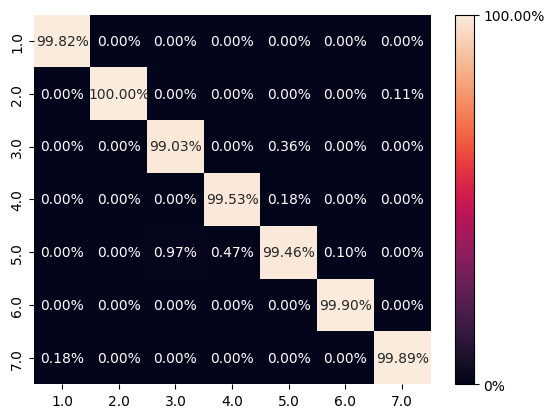

In [26]:
kn.fit(X_train, y_train)
plot_confusion_matrix(kn, X_test, y_test)

### d. Bayesian classifier

Accuracy: 97.78%

Confusion matrix:


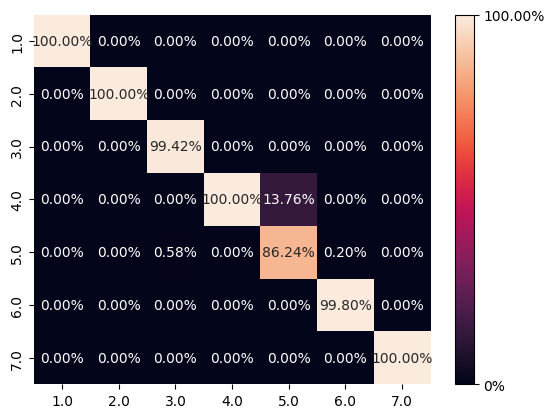

In [27]:
qd.fit(X_train, y_train)
plot_confusion_matrix(qd, X_test, y_test)

## 2.B Compare the results of the classifier

In the second part of the project we focused on the labels, in order to make predictions. After splitting the original labels into a train and test set we used the following methods to classify the points of the test set:

* naive Bayes classifier (sklearn)
* minimum Euclidean distance classifier (custom)
* k-nearest neighbor classifier (sklearn)
* Bayesian classifier (sklearn)

The results from the test set may be found in the following table:

|classifier|Accuracy (%)|
|---|---|
|Naive Bayes|98.13|
|Minimum Euclidean distance|95.91|
|k-nearest Neighbor| 99.72|
|Bayesian|97.78|

The first comment that can be made is that overall the models build fetched satisfactory results. The top performance is achieved using the k-nearest Neighbor method, followed by the Naive Bayes. The worst results were achieved using the Minimum Euclidean distance classifier. 

Looking at the confusion matrices we can see that most miss-classification occur between classes 4 and 5, with some error happening between 3 and 5. This makes sense for two reasons. First of all, the figure "RGB Visualization of abandance vector for each of 7 labels" clearly shows that these labels are similar to each other, in the picture, and also really nearby. Moreover, the material on all those cases is Fallow, of just different type, thus it is expected to have some errors there, for the least robust methods.

* We will now analyze the methods used in order to get a better understanding of the performance of each classifier.

The first question that comes to mind, concerns the performance of the minimum euclidean distance. The issue with this method is that the classes are modeled by normal distributions of equal diagonal covariance matrices of the form $\sigma^2I$. This, of course, is usually not the case and leads to some mistakes.

Moving on to the Bayes & Naive Bayes classifiers, we can see that the accuracy is slightly worse for the Bayes Classifier compared to that of the Naive Bayes Classifier. The difference between these two methods is that in Naive Bayes we assume that the that each 1-dimensional distribution is normal and all features are statistically independent. In theory this would have worse results than the Bayes Classifier since some correlation would definately happen. However due to the curse of dimensionality, estimating the parameters of the Bayes classifier for large values of $l$ (204) could be slightly inaccurate, for finite values of $N$. We assume that the performance is worse due to this fact in this case.

Finally the k-nearest Neighbor achieves an almost perfect separation of the classes as seens from the corresponding heatmap.

# Part 3 (Combination)

For this part of the project we will use the best methods obtained from the classification and regression task and plot the results classes using the operational dataset. 

In order to re-create the operational dataset in the classification task, an iterator, over the predictions was used, and the image with the known dimesions (220x120) was reconstructed. The results may be found below.

Running...............................................

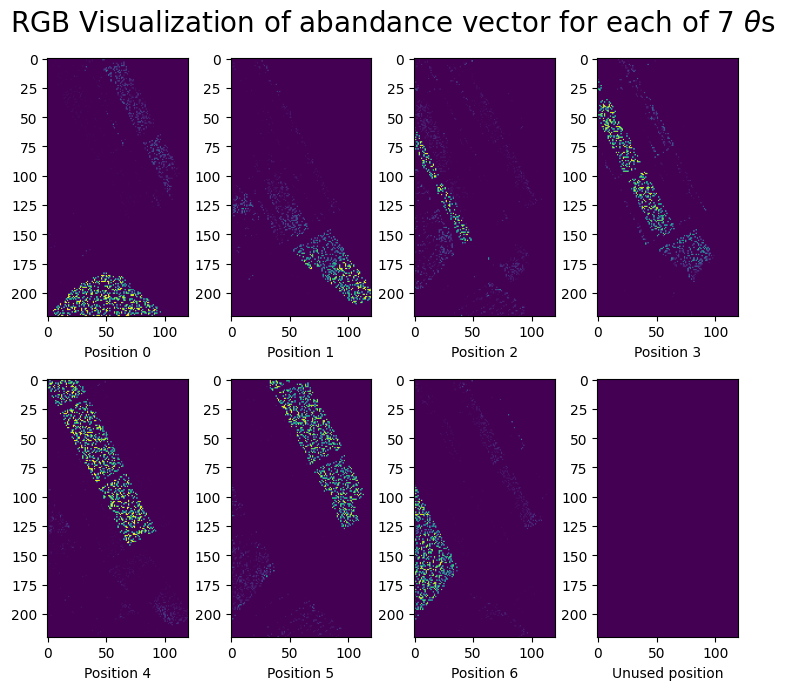

In [28]:
# define a table with zeros
theta_FCLS = np.zeros(shape=(220,120,7))

# iterate throughput the labels table and if the label in non zero calculate theta for y [204x1] and X [204x7]
print('Running...', end='')
for i, row in enumerate(Operational_Set):
    for j, l in enumerate(row):
        if l != 0:
            y_row = y[i,j,:].reshape(-1,1)
            theta_FCLS[i,j] = FCLS(y_row.astype(np.double).T, X.astype(np.double).T)
    if i%5 == 0:
        print('.', end='')

plot_endmembers(theta_FCLS) 

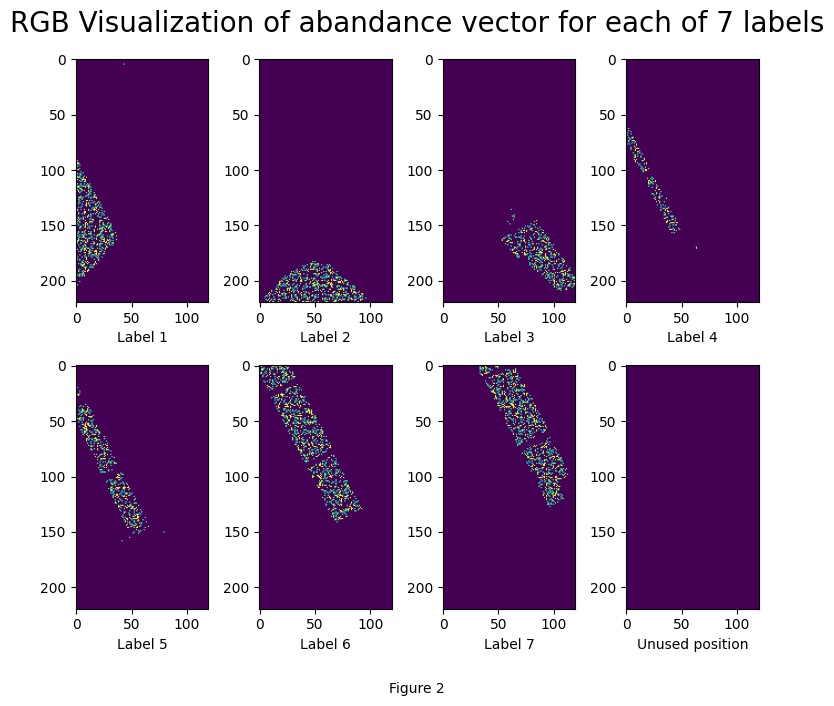

In [29]:
# Make prediction using kn method
predicted = kn.predict(X_opt)

# define a table with zeros
kn_pred = np.zeros(shape=(220,120))

# create iterator
p_it = iter(predicted)
for i, row in enumerate(Operational_Set):
    for j, l in enumerate(row):
        if l != 0:
            kn_pred[i,j] = next(p_it) # replace the value of the element in position i,j with the next one in the iterator
plot_labels(kn_pred, 2)

Looking at the bibliography for more information regarding Spectral unmixing we read that *"Spectral unmixing is a standard technique for spectral mixture analysis that infers a set of pure spectral signatures, called endmembers, and fractions of these endmembers, called abundances."*. Comparing the results from the two figures above, we can see that generally, the classification algorithms have better performance, than the regression task. 

In this particular case, the regression task is actually wokring as a classifier, since we are trying to separate the labels from each endmember and find one actual unique value for each pixel. It makes sense that a classification algorithm would be more suitable for this job, and as seen from the results the accuracy is almost 100%. 

The idea of combining the two methods could have some value, in case the results were not that good in the classfication part. Each method could work as a filter, which, with the appropriate combinatio, would generate a final, more accurate result.